# Bitcoin LSTM

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [151]:
data = pd.read_csv('/Users/kyleevans-lee/proj/notebooks/crypto/Binance_BTCUSDT_minute.csv')[30:]
# data = data.drop(columns=['Unnamed: 0'])
data.index = data.date
data = data.drop(columns=['date'])
data = data[data.index >'2021-05-20']
data =data.drop(columns=['symbol'])
data=data.drop(columns=['Unnamed: 0'])
# making rolling data
data = data[(pd.DataFrame(range(data.shape[0]))[0]%30==0).values]

memory_len = 10

In [158]:
data_cols = data.columns
data = data[['open', 'high', 'low', 'close', 'tradecount', 'high30min']]
target_col_index = 5

In [154]:
# adding 30 min rolling window
# data = pd.read_csv('/Users/kyleevans-lee/proj/notebooks/crypto/Binance_BTCUSDT_minute.csv')
# min30=[0]*30
# for i in range(30,data.shape[0]):
#     min30.append(max(data.high[i-30:i]))
# data['high30min'] = min30
# data.to_csv('/Users/kyleevans-lee/proj/notebooks/crypto/Binance_BTCUSDT_minute.csv')

# normalize


In [157]:
training_data = data[data.index< '2021-06-25'].copy()
test_data = data[data.index> '2021-06-25'].copy()

#training_data =training_data.drop(['unix'], axis = 1)
training_data.index = range(training_data.shape[0])

#test_data =test_data.drop(['unix'], axis = 1)
test_data.index = range(test_data.shape[0])

test_df=test_data.copy()
training_df=training_data.copy()

scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)



Batching

In [159]:
X_train = [] 
Y_train = []
print(training_data.shape)
for i in range(memory_len, training_data.shape[0]):
    X_train.append(training_data[i-memory_len:i])
    Y_train.append(training_data[i,target_col_index])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(1592, 6)


(1582, 10, 6)

In [160]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [168]:
#Initialize the RNN
X_train.shape[3]

(1582, 10, 6)

In [170]:
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, 
               input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 10, 50)            11400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 10, 60)            26640     
_________________________________________________________________
dropout_25 (Dropout)         (None, 10, 60)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 10, 80)            45120     
_________________________________________________________________
dropout_26 (Dropout)         (None, 10, 80)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 120)              

In [171]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [172]:
history= model.fit(X_train, Y_train, epochs = 5, batch_size =50, validation_split=0.1)

Epoch 1/5
29/29 [==============================] - 5s 36ms/step - loss: 0.0930 - val_loss: 0.0364
Epoch 2/5
29/29 [==============================] - 1s 20ms/step - loss: 0.0187 - val_loss: 0.0198
Epoch 3/5
29/29 [==============================] - 1s 21ms/step - loss: 0.0141 - val_loss: 0.0260
Epoch 4/5
29/29 [==============================] - 1s 21ms/step - loss: 0.0117 - val_loss: 0.0238
Epoch 5/5
29/29 [==============================] - 1s 23ms/step - loss: 0.0111 - val_loss: 0.0183


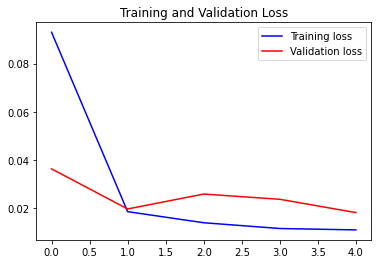

In [173]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [246]:
#model.save('lstm2_2month_30minfuture_rolling_10_blocks')
import pickle
pickle.dump(scaler,open('lstm10_hour_5features_scaler.pkl','wb')) 


# Now lets test the model

In [175]:
test_data.index = range(test_data.shape[0])
test_data.columns

Index(['open', 'high', 'low', 'close', 'tradecount', 'high30min'], dtype='object')

Format the test data

In [177]:
test_data = data[data.index> '2021-06-25'].copy()
#test_data =test_data.drop(['unix'], axis = 1)
test_data.index = range(test_data.shape[0])

test_df = test_data.copy()
test_data = scaler.transform(test_data)
test_data

array([[0.35626691, 0.35577146, 0.3680487 , 0.36342182, 0.0087164 ,
        0.35063918],
       [0.36398921, 0.36280956, 0.37590783, 0.36991953, 0.00069986,
        0.32969642],
       [0.36421237, 0.36248233, 0.37510138, 0.36930628, 0.0029903 ,
        0.33276489],
       ...,
       [0.39164219, 0.39656584, 0.40278075, 0.40237707, 0.0517576 ,
        0.37412492],
       [0.43705896, 0.43515539, 0.44202711, 0.43656245, 0.03680611,
        0.40540788],
       [0.42468912, 0.42490195, 0.43459698, 0.43205648, 0.02446318,
        0.42260257]])

In [178]:
X_test = []
Y_test = []
inputs = test_data.copy()
#inputs = training_data.copy()

In [179]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-memory_len:i]) 
    Y_test.append(inputs[i,target_col_index ])
X_test, Y_test = np.array(X_test), np.array(Y_test) 
print(X_test.shape, Y_test.shape)
test_df=test_df.iloc[60:]


(661, 10, 6) (661,)


In [222]:
len(inputs),len(X_test)

(721, 661)

In [239]:
Y_test1 = scaler.inverse_transform(inputs[60:])[:,5]
Y_pred = model.predict(X_test)
Y_pred1=scaler.inverse_transform([list(np.append([0]*5,x)) for x in Y_pred])[:,5]

Y_test1[:10],Y_pred1[:10]

(array([32872.66, 32999.94, 32972.  , 33038.88, 32878.66, 32958.  ,
        32924.24, 32800.  , 32697.29, 32681.53]),
 array([33431.99723397, 33447.18250189, 33481.59552841, 33503.27125854,
        33497.50640059, 33496.05745487, 33492.81938929, 33480.03608266,
        33476.66488907, 33476.1482166 ]))

In [242]:
actual_up= np.array(Y_test1[:1]<Y_test1[1:])
pred_up = np.array(Y_test1[:1]<Y_pred1[1:])

# test_up= np.array(Y_test[:1]<Y_test[1:])
# pred_up = np.array(Y_pred1[:1]<Y_pred1[1:])

In [250]:
import sklearn.metrics
sklearn.metrics.confusion_matrix(pred_up,actual_up)

array([[ 40,   0],
       [ 46, 574]])

In [243]:
count =0
for i,j in zip(actual_up,pred_up):
    if i==j:
        count +=1
count/(len(actual_up)-1)

0.9317147192716236

In [248]:
actual_up.sum()/len(pred_up)

0.8696969696969697

In [245]:
model.save('lstm10hour_5features')

INFO:tensorflow:Assets written to: lstm10hour_5features/assets


In [ ]:
# Y_pred=model.predict(X_test[:1000])
# scale = scaler.scale_[0]
# Y_test1 = Y_test[-1000:]*1/scale+scaler.data_min_[0]
# Y_test1
#Y_pred1 = Y_pred-scaler.max_[0]#*1/scale+scaler.data_min_[0]


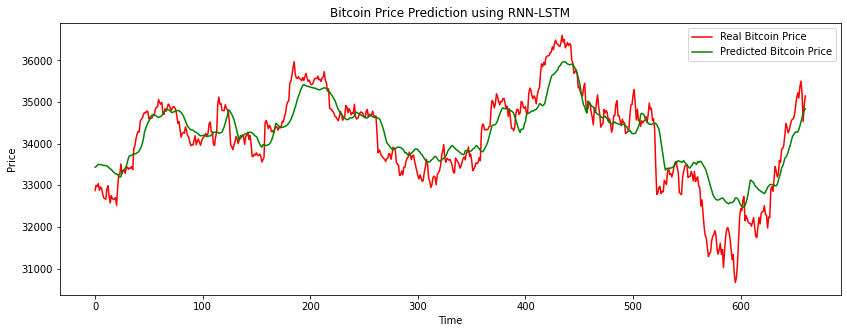

In [244]:
plt.figure(figsize=(14,5))
plt.plot(Y_test1, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred1, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [194]:
Y_pred = model.predict(X_train[-1000:]) 

scale = scaler.scale_[0]
Y_train1 = Y_train*1/scale+scaler.data_min_[0]
Y_pred1 = Y_pred*1/scale+scaler.data_min_[0]
Y_pred1[-3]

array([38067.82], dtype=float32)

[0, 0, 0, 0, 0, 45]

In [ ]:
plt.figure(figsize=(14,5))
plt.plot([round(x,3) for x in Y_train1[-1000:]], color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred1, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
Y_pred = model.predict(X_train[-10:]) 
np.ravel(Y_pred*1/scale+scaler.data_min_[0])

In [ ]:
scaler.data_min_[0]

In [ ]:
np.unique([x for x in X_test[-1000:]])

In [ ]:
X_test[-1000:][0]

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_train[-1000:], Y_train[-1000:], batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_train[-3:])

In [ ]:
model.predict(X_train[-3:])

In [ ]:
Y_train[-3:]*scaler.scale_[0]+scaler.data_min_[0]

In [ ]:
[x[0] for x in X_train[-3:]*scaler.scale_[0]+scaler.data_min_[0]]

In [ ]:
data.open.max()

In [ ]:
sum((data.high[1:]-data.close[:-1])/data.close[:-1]>.0075)/data.shape[0]*60*24